# Jaffle Shop Data Analysis - Final Project

## Instructions
You have been hired as a data analyst for Jaffle Shop, a growing chain of gourmet toasted sandwich restaurants. The executive team needs insights to make strategic business decisions.

Using the provided datasets and Python Polars, analyze the business performance and provide data-driven recommendations. You must use Polars for all data manipulation and analysis.

## Available Data
- `Customers.csv`: Customer information
- `Orders.csv`: Order transactions with totals and timestamps
- `Items.csv`: Individual items within each order
- `Products.csv`: Product catalog with prices and descriptions
- `Stores.csv`: Store locations and opening dates
- `Supplies.csv`: Supply costs for each product

**Time Limit: 90 minutes**

## Setup and Data Loading

In [1]:
# Import necessary libraries
import polars as pl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
# Load all datasets
# TODO: Update these paths to the actual location of your data files
customers = pl.read_csv('/content/Customers.csv')
orders = pl.read_csv('/content/Orders.csv')
items = pl.read_csv('/content/Items.csv')
products = pl.read_csv('/content/Products.csv')
stores = pl.read_csv('/content/Stores.csv')
supplies = pl.read_csv('/content/Supplies.csv')

# Display basic information about each dataset
print("Dataset shapes:")
print(f"Customers: {customers.shape}")
print(f"Orders: {orders.shape}")
print(f"Items: {items.shape}")
print(f"Products: {products.shape}")
print(f"Stores: {stores.shape}")
print(f"Supplies: {supplies.shape}")

FileNotFoundError: No such file or directory (os error 2): /content/Customers.csv

## Question 1: Revenue Performance Analysis

The CFO wants to understand the company's financial performance across different dimensions. Analyze:
- What is the total revenue generated by Jaffle Shop? (Store result in variable: `total_revenue`)
- How does revenue vary by store location? (Store result in variable: `revenue_by_store`)
- What are the monthly revenue trends? (Store result in variable: `monthly_revenue_trends`)
- Which day of the week generates the most revenue? (Store result in variable: `revenue_by_day_of_week`)
- Include at least one chart for one of these questions

In [ ]:
# Q1.1: Calculate total revenue

total_revenue = orders.select(pl.col('order_total')).sum()
print(f"Jaffle Shop's total revenues are ${total_revenue.item():,.2f}")

Jaffle Shop's total revenues are $66,038,193.00


In [ ]:
# Q1.2: Revenue by store location

revenue_by_store = (
    orders.join(stores, left_on='store_id', right_on='id')
    .group_by('name')
    .agg(pl.col('order_total').sum().alias('total_revenue'))
    .sort('total_revenue', descending=True)
)

print("Revenue by store location:")
print(revenue_by_store)

print("It seems that, based on total revenue, Jaffle Shop's store in Philadelphia is performing the best.")

Revenue by store location:
shape: (2, 2)
┌──────────────┬───────────────┐
│ name         ┆ total_revenue │
│ ---          ┆ ---           │
│ str          ┆ i64           │
╞══════════════╪═══════════════╡
│ Philadelphia ┆ 43215565      │
│ Brooklyn     ┆ 22822628      │
└──────────────┴───────────────┘
It seems that, based on total revenue, Jaffle Shop's store in Philadelphia is performing the best.


Monthly revenue trends:
shape: (12, 2)
┌────────────┬───────────────┐
│ year_month ┆ total_revenue │
│ ---        ┆ ---           │
│ str        ┆ i64           │
╞════════════╪═══════════════╡
│ 2016-09    ┆ 1644922       │
│ 2016-10    ┆ 1956651       │
│ 2016-11    ┆ 2552662       │
│ 2016-12    ┆ 3307337       │
│ 2017-01    ┆ 3821291       │
│ …          ┆ …             │
│ 2017-04    ┆ 7392014       │
│ 2017-05    ┆ 8469909       │
│ 2017-06    ┆ 8617148       │
│ 2017-07    ┆ 8585320       │
│ 2017-08    ┆ 9332296       │
└────────────┴───────────────┘


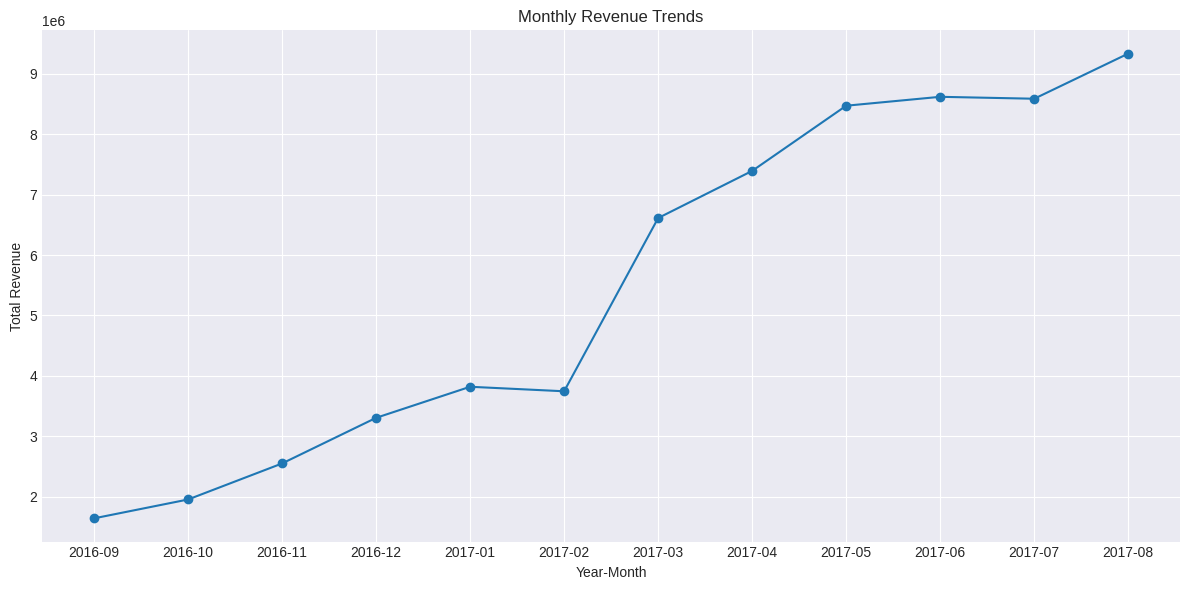

In [ ]:
# Q1.3: Monthly revenue trends

import matplotlib.pyplot as plt

monthly_revenue_trends = (
    orders
    .with_columns(
        pl.col("ordered_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S")
    )
    .with_columns(
        pl.col("ordered_at").dt.strftime("%Y-%m").alias("year_month")
    )
    .group_by("year_month")
    .agg(pl.col("order_total").sum().alias("total_revenue"))
    .sort("year_month")
)

print("Monthly revenue trends:")
print(monthly_revenue_trends)

year_month = monthly_revenue_trends["year_month"].to_list()
total_revenue = monthly_revenue_trends["total_revenue"].to_list()

plt.figure(figsize=(12, 6))
plt.plot(year_month, total_revenue, marker="o")
plt.title("Monthly Revenue Trends")
plt.xlabel("Year-Month")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Q1.4: Revenue by day of week

revenue_by_day_of_week = (
    orders
    .with_columns(
        pl.col("ordered_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S")
    )
    .with_columns(
        pl.col("ordered_at").dt.strftime("%A").alias("day_of_week")
    )
    .group_by("day_of_week")
    .agg(pl.col("order_total").sum().alias("total_revenue"))
    .sort("total_revenue", descending=True)
)

print("Revenue by day of the week:")
print(revenue_by_day_of_week)

print("Therefore, based on the data from the orders table, Wednesdays generate the most revenue.")

Revenue by day of the week:
shape: (7, 2)
┌─────────────┬───────────────┐
│ day_of_week ┆ total_revenue │
│ ---         ┆ ---           │
│ str         ┆ i64           │
╞═════════════╪═══════════════╡
│ Wednesday   ┆ 10834569      │
│ Thursday    ┆ 10829195      │
│ Tuesday     ┆ 10814455      │
│ Friday      ┆ 10758715      │
│ Monday      ┆ 10611971      │
│ Sunday      ┆ 6207799       │
│ Saturday    ┆ 5981489       │
└─────────────┴───────────────┘
Therefore, based on the data from the orders table, Wednesdays generate the most revenue.


## Question 2: Product Performance

The Product Manager needs insights about the menu items:
- What is the revenue contribution of each product category (jaffles vs beverages)? (Store result in variable: `revenue_by_category`)
- What is the average price of products by type (jaffles vs beverages)?
- Include at least one chart to answer one of the above questions.

In [ ]:
# Q2.1: Revenue by product category
# Your code here
revenue_by_category = (
    items
    .join(products, left_on="sku", right_on="sku")
    .join(orders, left_on="order_id", right_on="id")
    .with_columns(
        (pl.col("price")).alias("item_price")
    )
    .group_by("type")
    .agg((pl.col("item_price").sum()).alias("total_revenue"))
    .with_columns(
        (pl.col("total_revenue") / pl.col("total_revenue").sum()).alias("revenue_contribution")
    )
    .sort("total_revenue", descending=True)
)

print("Revenue by product category:")
print(revenue_by_category)


Revenue by product category:
shape: (2, 3)
┌──────────┬───────────────┬──────────────────────┐
│ type     ┆ total_revenue ┆ revenue_contribution │
│ ---      ┆ ---           ┆ ---                  │
│ str      ┆ i64           ┆ f64                  │
╞══════════╪═══════════════╪══════════════════════╡
│ beverage ┆ 39836200      ┆ 0.635173             │
│ jaffle   ┆ 22880900      ┆ 0.364827             │
└──────────┴───────────────┴──────────────────────┘


shape: (2, 2)
┌──────────┬───────────┐
│ type     ┆ avg_price │
│ ---      ┆ ---       │
│ str      ┆ f64       │
╞══════════╪═══════════╡
│ jaffle   ┆ 1200.0    │
│ beverage ┆ 560.0     │
└──────────┴───────────┘


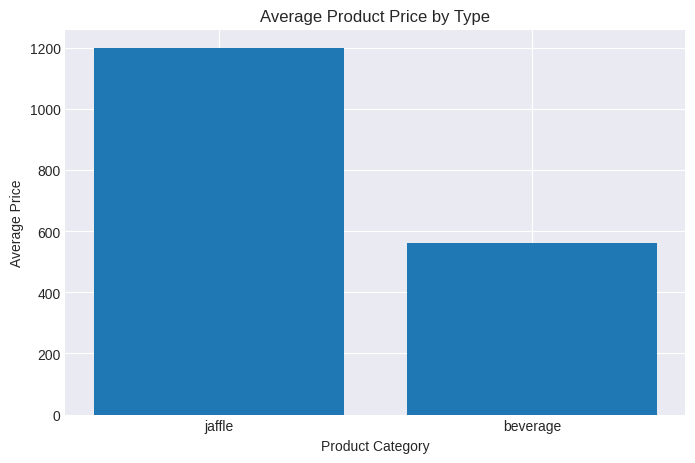

In [ ]:
# Q2.2 Average price of products by type

avg_price_by_type = (
    products
    .group_by("type")
    .agg(pl.col("price").mean().alias("avg_price"))
    .sort("avg_price", descending=True)
)

print(avg_price_by_type)

plt.figure(figsize=(8,5))
plt.bar(avg_price_by_type["type"], avg_price_by_type["avg_price"])
plt.title("Average Product Price by Type")
plt.xlabel("Product Category")
plt.ylabel("Average Price")
plt.show()

## Question 3: Store Expansion Strategy

The Operations Director is planning expansion strategies:
- Which stores have the highest revenue per day since opening? (Store result in variable: `revenue_per_day_by_store`)
- What is the relationship between local tax rates and store performance? (Store result in variable: `tax_rate_performance`)
- Include at least one chart to answer one of the above questions.

In [ ]:
 Q3.1: Revenue per day since opening by store

orders_datetime = orders.with_columns(
    pl.col("ordered_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S").alias("ordered_at_datetime")
)

stores_datetime = stores.with_columns(
    pl.col("opened_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S").alias("opened_at_datetime")
)

orders_stores = orders_datetime.join(stores_datetime, left_on="store_id", right_on="id")

store_operating_days = (
    orders_stores
    .group_by("store_id")
    .agg([
        pl.col("ordered_at_datetime").max().alias("last_order_date"),
        pl.first("opened_at_datetime").alias("opened_at_datetime")
    ])
    .with_columns(
        ((pl.col("last_order_date") - pl.col("opened_at_datetime")).dt.total_days() + 1).alias("operating_days")
    )
)

revenue_by_store_total = (
    orders
    .group_by("store_id")
    .agg(pl.sum("order_total").alias("total_revenue"))
)

revenue_per_day_by_store = (
    revenue_by_store_total
    .join(store_operating_days.select(["store_id", "operating_days"]), on="store_id")
    .with_columns(
        (pl.col("total_revenue") / pl.col("operating_days")).alias("revenue_per_day")
    )
    .join(stores.select(["id", "name"]), left_on="store_id", right_on="id")
    .sort("revenue_per_day", descending=True)
)

print("Revenue per Day since Opening by Store:")
print(revenue_per_day_by_store)


Revenue per Day since Opening by Store:
shape: (2, 5)
┌────────────────────────────────┬───────────────┬────────────────┬─────────────────┬──────────────┐
│ store_id                       ┆ total_revenue ┆ operating_days ┆ revenue_per_day ┆ name         │
│ ---                            ┆ ---           ┆ ---            ┆ ---             ┆ ---          │
│ str                            ┆ i64           ┆ i64            ┆ f64             ┆ str          │
╞════════════════════════════════╪═══════════════╪════════════════╪═════════════════╪══════════════╡
│ a2a24e87-dec8-4f5d-9c9e-0e9849 ┆ 22822628      ┆ 173            ┆ 131922.705202   ┆ Brooklyn     │
│ …                              ┆               ┆                ┆                 ┆              │
│ a9128331-08d7-41a2-b615-21283e ┆ 43215565      ┆ 365            ┆ 118398.808219   ┆ Philadelphia │
│ …                              ┆               ┆                ┆                 ┆              │
└────────────────────────────────┴───

Tax Rate vs Performance:
shape: (2, 4)
┌─────────────────────────────────┬───────────────┬──────────────┬──────────┐
│ store_id                        ┆ total_revenue ┆ name         ┆ tax_rate │
│ ---                             ┆ ---           ┆ ---          ┆ ---      │
│ str                             ┆ i64           ┆ str          ┆ f64      │
╞═════════════════════════════════╪═══════════════╪══════════════╪══════════╡
│ a9128331-08d7-41a2-b615-21283e… ┆ 43215565      ┆ Philadelphia ┆ 0.06     │
│ a2a24e87-dec8-4f5d-9c9e-0e9849… ┆ 22822628      ┆ Brooklyn     ┆ 0.04     │
└─────────────────────────────────┴───────────────┴──────────────┴──────────┘


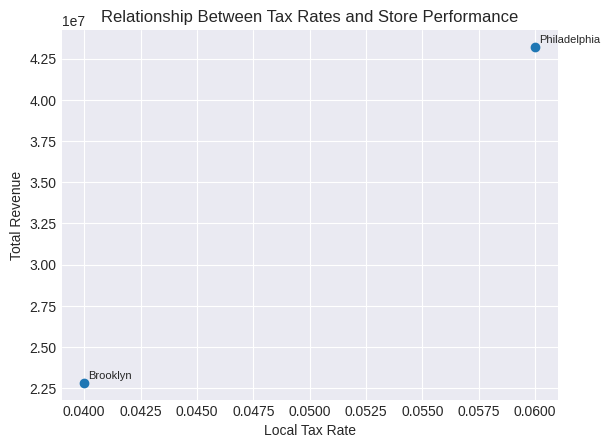

In [ ]:
# Q3.2: Tax rates vs store performance

tax_rate_performance = (
    orders
    .group_by("store_id")
    .agg(pl.col("order_total").sum().alias("total_revenue"))
    .join(stores_datetime.select(["id", "name", "tax_rate"]), left_on="store_id", right_on="id")
)

print("Tax Rate vs Performance:")
print(tax_rate_performance)

tax_rates = tax_rate_performance["tax_rate"].to_list()
revenues  = tax_rate_performance["total_revenue"].to_list()
names     = tax_rate_performance["name"].to_list()

import matplotlib.pyplot as plt

plt.scatter(tax_rates, revenues)
plt.xlabel("Local Tax Rate")
plt.ylabel("Total Revenue")
plt.title("Relationship Between Tax Rates and Store Performance")

for x, y, label in zip(tax_rates, revenues, names):
    plt.annotate(label, (x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)

plt.show()




## Question 4: Customer Behavior Analysis

The Marketing Manager wants to understand customer patterns:
- What is the distribution of order values? (Store result in variable: `order_value_distribution`)
- How many customers are repeat customers? (Store result in variable: `repeat_customer_analysis`)
- Which customers contribute the most to revenue? (Store result in variable: `top_revenue_customers`)

In [ ]:
# Q4.1: Distribution of order values

order_value_distribution = orders.select(pl.col('order_total')).describe()

print("Order Value Distribution:")
print(order_value_distribution)

Order Value Distribution:
shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ order_total │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 63148.0     │
│ null_count ┆ 0.0         │
│ mean       ┆ 1045.76856  │
│ std        ┆ 1025.930713 │
│ min        ┆ 0.0         │
│ 25%        ┆ 530.0       │
│ 50%        ┆ 636.0       │
│ 75%        ┆ 1165.0      │
│ max        ┆ 10281.0     │
└────────────┴─────────────┘


In [ ]:
# Q4.2: Repeat customers analysis

customer_order_counts = (
    orders
    .group_by("customer")
    .agg(pl.len().alias("order_count"))
)

repeat_customers = customer_order_counts.filter(pl.col("order_count") > 1)

num_repeat_customers = repeat_customers.height
num_total_customers = orders.select(pl.col("customer")).n_unique()
percentage_repeat_customers = (
    (num_repeat_customers / num_total_customers) * 100 if num_total_customers > 0 else 0
)

repeat_customer_analysis = pl.DataFrame({
    "Total_Customers": [num_total_customers],
    "Repeat_Customers": [num_repeat_customers],
    "Percentage_Repeat_Customers": [percentage_repeat_customers]
})

print("Repeat Customer Analysis:")
print(repeat_customer_analysis)

Repeat Customer Analysis:
shape: (1, 3)
┌─────────────────┬──────────────────┬─────────────────────────────┐
│ Total_Customers ┆ Repeat_Customers ┆ Percentage_Repeat_Customers │
│ ---             ┆ ---              ┆ ---                         │
│ i64             ┆ i64              ┆ f64                         │
╞═════════════════╪══════════════════╪═════════════════════════════╡
│ 930             ┆ 920              ┆ 98.924731                   │
└─────────────────┴──────────────────┴─────────────────────────────┘


In [ ]:
# Q4.3: Top revenue contributors

top_revenue_customers = (
    orders
    .group_by("customer")
    .agg(pl.sum("order_total").alias("total_revenue"))
    .join(customers.select(["id", "name"]), left_on="customer", right_on="id")
    .sort("total_revenue", descending=True)
)

print("Top Revenue Customers:")
print(top_revenue_customers.head(10))

Top Revenue Customers:
shape: (10, 3)
┌─────────────────────────────────┬───────────────┬──────────────────────┐
│ customer                        ┆ total_revenue ┆ name                 │
│ ---                             ┆ ---           ┆ ---                  │
│ str                             ┆ i64           ┆ str                  │
╞═════════════════════════════════╪═══════════════╪══════════════════════╡
│ ea3ada4c-8ffa-4e73-a51f-27711f… ┆ 262647        ┆ David Leonard        │
│ 4fb3b92c-29cc-410f-a898-9784c4… ┆ 259037        ┆ Jesse Moore          │
│ 99facd33-7b11-4955-aa0d-ccd118… ┆ 258515        ┆ Diane Davis          │
│ 8bbf796d-0862-41c6-b533-38d6c2… ┆ 252703        ┆ Holly Johnson        │
│ bc94ad77-6703-48d9-85d9-7908e7… ┆ 249821        ┆ Gregory Hayes        │
│ 3ddc958e-73f5-4fe9-804e-d63c8b… ┆ 247510        ┆ Julie Robinson       │
│ 0b92fd92-9200-47fe-9b57-9ada88… ┆ 246325        ┆ Christopher Robinson │
│ a54f0762-0ac2-4821-bb45-835fd4… ┆ 244102        ┆ Douglas Bu

## Question 5: Profitability Deep Dive

The CEO needs a comprehensive profitability analysis:
- Calculate the gross margin for each product (consider supply costs) (Store result in variable: `product_margins`)
- Which products have the highest profit margins? (Store result in variable: `highest_margin_products`)
- What is the relationship between order size and profitability? (Store result in variable: `order_size_profitability`)
- How does profitability vary across different stores? (Store result in variable: `store_profitability`)

In [ ]:
# Q5.1: Calculate gross margin per product

product_sales = (
    items
    .join(products, left_on="sku", right_on="sku")
    .join(supplies, left_on="sku", right_on="sku")
    .with_columns([
        pl.col("price").alias("revenue_per_unit"),
        pl.col("cost").alias("cost_per_unit")
    ])
    .with_columns(
        (pl.col("revenue_per_unit") - pl.col("cost_per_unit")).alias("profit_per_unit")
    )
)

product_margins = (
    product_sales
    .group_by(["sku", "name"])
    .agg([
        pl.sum("revenue_per_unit").alias("total_revenue"),
        pl.sum("cost_per_unit").alias("total_cost"),
        pl.sum("profit_per_unit").alias("total_profit")
    ])
    .with_columns(
        ((pl.col("total_profit") / pl.col("total_revenue")) * 100).alias("gross_margin_pct")
    )
    .sort("gross_margin_pct", descending=True)
)

print("Product Margins:")
print(product_margins)



Product Margins:
shape: (10, 6)
┌─────────┬─────────────────────────┬───────────────┬────────────┬──────────────┬──────────────────┐
│ sku     ┆ name                    ┆ total_revenue ┆ total_cost ┆ total_profit ┆ gross_margin_pct │
│ ---     ┆ ---                     ┆ ---           ┆ ---        ┆ ---          ┆ ---              │
│ str     ┆ str                     ┆ i64           ┆ i64        ┆ i64          ┆ f64              │
╞═════════╪═════════════════════════╪═══════════════╪════════════╪══════════════╪══════════════════╡
│ JAF-001 ┆ nutellaphone who dis?   ┆ 29337000      ┆ 461010     ┆ 28875990     ┆ 98.428571        │
│ JAF-005 ┆ mel-bun                 ┆ 36710400      ┆ 913936     ┆ 35796464     ┆ 97.510417        │
│ JAF-004 ┆ flame impala            ┆ 47174400      ┆ 1284192    ┆ 45890208     ┆ 97.277778        │
│ BEV-001 ┆ tangaroo                ┆ 43113000      ┆ 1178422    ┆ 41934578     ┆ 97.266667        │
│ BEV-004 ┆ for richer or pourover  ┆ 39807600      ┆ 11657

In [ ]:
# Q5.2: Products with highest profit margins

highest_margin_products = product_margins.sort("gross_margin_pct", descending=True).head(5)

print("Highest Margin Products:")
print(highest_margin_products)


Highest Margin Products:
shape: (5, 6)
┌─────────┬─────────────────────────┬───────────────┬────────────┬──────────────┬──────────────────┐
│ sku     ┆ name                    ┆ total_revenue ┆ total_cost ┆ total_profit ┆ gross_margin_pct │
│ ---     ┆ ---                     ┆ ---           ┆ ---        ┆ ---          ┆ ---              │
│ str     ┆ str                     ┆ i64           ┆ i64        ┆ i64          ┆ f64              │
╞═════════╪═════════════════════════╪═══════════════╪════════════╪══════════════╪══════════════════╡
│ JAF-001 ┆ nutellaphone who dis?   ┆ 29337000      ┆ 461010     ┆ 28875990     ┆ 98.428571        │
│ JAF-005 ┆ mel-bun                 ┆ 36710400      ┆ 913936     ┆ 35796464     ┆ 97.510417        │
│ JAF-004 ┆ flame impala            ┆ 47174400      ┆ 1284192    ┆ 45890208     ┆ 97.277778        │
│ BEV-001 ┆ tangaroo                ┆ 43113000      ┆ 1178422    ┆ 41934578     ┆ 97.266667        │
│ BEV-004 ┆ for richer or pourover  ┆ 39807600      

In [ ]:
# Q5.3: Order size vs profitability

items_with_profit = (
    items
    .join(products, left_on="sku", right_on="sku")
    .join(supplies, left_on="sku", right_on="sku")
    .with_columns(
        (pl.col("price") - pl.col("cost")).alias("profit_per_unit")
    )
)

order_size_profitability = (
    items_with_profit
    .group_by("order_id")
    .agg([
        pl.count("id").alias("order_size"),
        pl.sum("profit_per_unit").alias("total_profit")
    ])
)

print("Order Size vs Profitability:")
print(order_size_profitability)



Order Size vs Profitability:
shape: (62_642, 3)
┌─────────────────────────────────┬────────────┬──────────────┐
│ order_id                        ┆ order_size ┆ total_profit │
│ ---                             ┆ ---        ┆ ---          │
│ str                             ┆ u32        ┆ i64          │
╞═════════════════════════════════╪════════════╪══════════════╡
│ 2c4b4ca5-5e05-4ff3-aa62-20ddce… ┆ 4          ┆ 2718         │
│ ea4cceb4-cb37-4560-9815-1103e9… ┆ 5          ┆ 2918         │
│ 06d1bca7-93f9-4e84-a202-82686d… ┆ 4          ┆ 2718         │
│ c806944e-2400-4b33-af93-cdf22a… ┆ 4          ┆ 2718         │
│ 6e77e422-7172-4318-831b-a51f94… ┆ 4          ┆ 2718         │
│ …                               ┆ …          ┆ …            │
│ dc8f0ced-1be0-4758-9520-d4c2cc… ┆ 5          ┆ 1937         │
│ 565004ed-c3ce-4ff1-abd1-59a5fe… ┆ 6          ┆ 2825         │
│ c8534c68-1c68-48af-9134-2951f3… ┆ 5          ┆ 2918         │
│ 2cb1a233-2984-40da-8ee7-00369d… ┆ 5          ┆ 2846   

In [ ]:
# Q5.4: Profitability by store

items_orders_stores = (
    items_with_profit
    .join(orders.select(["id", "store_id"]), left_on="order_id", right_on="id")
)

store_profitability = (
    items_orders_stores
    .group_by("store_id")
    .agg(pl.sum("profit_per_unit").alias("total_profit"))
    .join(stores.select(["id", "name"]), left_on="store_id", right_on="id")
    .sort("total_profit", descending=True)
)

print("Store Profitability:")
print(store_profitability)



Store Profitability:
shape: (2, 3)
┌─────────────────────────────────┬──────────────┬──────────────┐
│ store_id                        ┆ total_profit ┆ name         │
│ ---                             ┆ ---          ┆ ---          │
│ str                             ┆ i64          ┆ str          │
╞═════════════════════════════════╪══════════════╪══════════════╡
│ a9128331-08d7-41a2-b615-21283e… ┆ 239888460    ┆ Philadelphia │
│ a2a24e87-dec8-4f5d-9c9e-0e9849… ┆ 128076641    ┆ Brooklyn     │
└─────────────────────────────────┴──────────────┴──────────────┘


## Question 6: Business Optimization Recommendations

Based on your analysis, provide three specific, data-driven recommendations to improve business performance. Support each recommendation with relevant metrics and visualizations.

### Recommendation 1:
We recommend combining the two most expensive jaffles with one beverage at a 20% discount. By analyzing customers who purchased the two most expensive jaffles, we simulated the impact if each of those orders had also included a beverage at a 20% discount (combo pricing). With that information we can compare the combos to current revenue from these products alone.

The metric is using a conservative 60% adoption of the combo by customers that order the two most expensive jaffles. As it can be shown below, there would be a clear increase, from only ordering the available products compare to give the option ot order a combo.

Top-2 jaffles: ['flame impala', 'the krautback']
Eligible orders (top-2, no beverage): 685
Assumed adoption: 60% -> 411 orders
Avg beverage price: $560.00 | Discounted: $448.00
Added revenue from combos (Top2 orders no bev 60% adopt X beverage with 20% disc): $184,128.00
Baseline revenue (eligible orders): $1,709,728.00
Scenario revenue (baseline + combos): $1,893,856.00 | Uplift: 10.77%


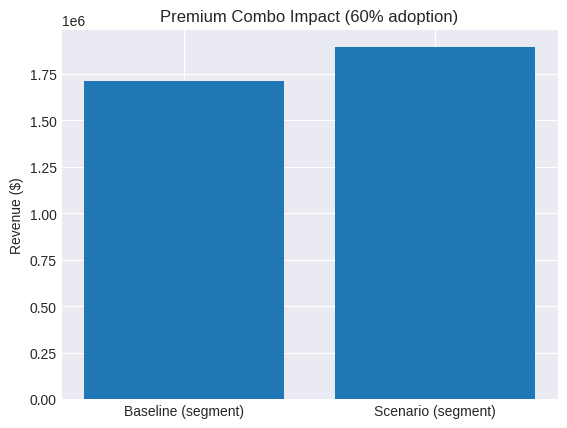

In [ ]:
# Supporting analysis for Recommendation 1

orders_dt = orders.with_columns(
    pl.col("ordered_at").str.to_datetime(strict=False)
)
stores_dt = stores.with_columns(
    pl.col("opened_at").str.to_datetime(strict=False)
)

COMBO_DISCOUNT = 0.20
COMBO_ADOPTION_RATE = 0.60

COMBO_DISCOUNT = 0.20
COMBO_ADOPTION_RATE = 0.60

# Top-2 most expensive jaffles
top2 = (
    products.filter(pl.col("type") == "jaffle")
    .sort("price", descending=True)
    .select(["sku", "name", "price"])
    .head(2)
)
top2_skus = top2["sku"].to_list()

# Average beverage price (for combo pricing)
avg_bev_price = (
    products.filter(pl.col("type") == "beverage")
    .select(pl.col("price").mean().alias("avg_bev_price"))
)[0, 0]
discounted_bev_price = avg_bev_price * (1 - COMBO_DISCOUNT)

# Orders containing any of the top-2 jaffles
orders_with_top2 = (
    items.filter(pl.col("sku").is_in(top2_skus))
    .select("order_id").unique()
    .with_columns(pl.lit(True).alias("has_top2"))
)

# Orders containing any beverage
orders_with_bev = (
    items.join(
        products.filter(pl.col("type")=="beverage").select("sku"),
        on="sku", how="inner"
    )
    .select("order_id").unique()
    .with_columns(pl.lit(True).alias("has_bev"))
)

# Eligible = orders with top-2 jaffle and NO beverage
eligible_orders = (
    orders.rename({"id":"order_id"})
    .select(["order_id", "order_total"])
    .join(orders_with_top2, on="order_id", how="left")
    .join(orders_with_bev,  on="order_id", how="left")
    .with_columns([
        pl.col("has_top2").fill_null(False),
        pl.col("has_bev").fill_null(False),
    ])
    .filter((pl.col("has_top2") == True) & (pl.col("has_bev") == False))
)

eligible_count   = eligible_orders.height
baseline_revenue = eligible_orders.select(pl.col("order_total").sum().alias("baseline"))[0, 0]

adopters         = int(round(eligible_count * COMBO_ADOPTION_RATE))
added_revenue    = adopters * discounted_bev_price
scenario_revenue = baseline_revenue + added_revenue
uplift_pct       = (added_revenue / baseline_revenue * 100.0) if baseline_revenue else 0.0


print(f"Top-2 jaffles: {top2.select('name').to_series().to_list()}")
print(f"Eligible orders (top-2, no beverage): {eligible_count}")
print(f"Assumed adoption: {COMBO_ADOPTION_RATE:.0%} -> {adopters} orders")
print(f"Avg beverage price: ${avg_bev_price:.2f} | Discounted: ${discounted_bev_price:.2f}")
print(f"Added revenue from combos (Top2 orders no bev 60% adopt X beverage with 20% disc): ${added_revenue:,.2f}")
print(f"Baseline revenue (eligible orders): ${baseline_revenue:,.2f}")
print(f"Scenario revenue (baseline + combos): ${scenario_revenue:,.2f} | Uplift: {uplift_pct:.2f}%")

# Bar Chart showing Combo Impact
plt.figure()
plt.bar(["Baseline (segment)", "Scenario (segment)"], [baseline_revenue, scenario_revenue])
plt.title("Premium Combo Impact (60% adoption)")
plt.ylabel("Revenue ($)")
plt.grid(True, axis="y")
plt.show()

### Recommendation 2:
Current sales show that the second most profitable jaffle consistently generates strong margins. If a new jaffle achieved the same share of sales as this product, overall revenues would increase proportionally, while also strengthening the perception of innovation and variety. This scenario highlights the potential upside of expanding the menu by offering the customer more options on the products with a stronger profit margin.

Note: We have use the second best product, since marketing theory shows that customer tends to focus mostly on the products in the middle price.

New product scenario (same share as 2nd-best margin):
shape: (1, 5)
┌───────────────────────┬───────────────────┬────────────┬─────────────────────┬───────────────────┐
│ second_best_jaffle    ┆ unit_gross_margin ┆ units_sold ┆ incremental_revenue ┆ incremental_gross │
│ ---                   ┆ ---               ┆ ---        ┆ ---                 ┆ ---               │
│ str                   ┆ i64               ┆ u32        ┆ i64                 ┆ i64               │
╞═══════════════════════╪═══════════════════╪════════════╪═════════════════════╪═══════════════════╡
│ nutellaphone who dis? ┆ 979               ┆ 3810       ┆ 4191000             ┆ 3729990           │
└───────────────────────┴───────────────────┴────────────┴─────────────────────┴───────────────────┘
Current total jaffle revenue: $22,880,900.00
New Product revenue (simulated): $4,191,000.00
Total revenue with New Product: $27,071,900.00  |  Increase: 18.32%


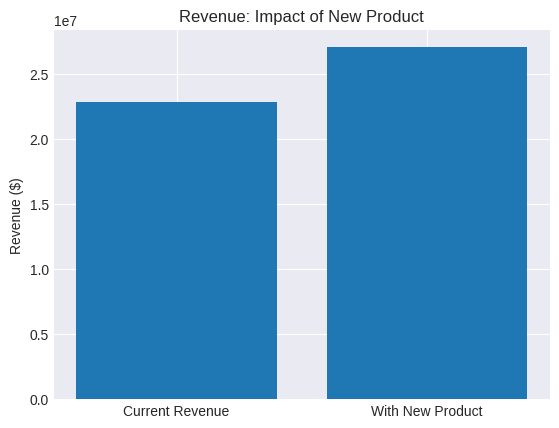

In [ ]:
# Supporting analysis for Recommendation 2

# Q6.2: New high-margin product (same share as 2nd-best unit margin)

supplies_per_sku = (
    supplies
    .group_by("sku")
    .agg(pl.sum("cost").alias("supply_cost_per_sku"))
)

products_margin = (
    products
    .join(supplies_per_sku, on="sku", how="left")
    .with_columns([
        pl.col("supply_cost_per_sku").fill_null(0),
        (pl.col("price") - pl.col("supply_cost_per_sku")).alias("unit_gross_margin")
    ])
)

sales_per_sku = (
    items
    .group_by("sku")
    .agg(pl.len().alias("units_sold"))
    .join(products.select(["sku","name","type","price"]), on="sku", how="left")
    .with_columns((pl.col("units_sold")*pl.col("price")).alias("revenue"))
)

jaffles_by_margin = (
    sales_per_sku
    .filter(pl.col("type")=="jaffle")
    .join(products_margin.select(["sku","unit_gross_margin"]), on="sku", how="left")
    .sort("unit_gross_margin", descending=True)
)

second = jaffles_by_margin.select(["name","units_sold","revenue","unit_gross_margin"]).slice(1, 1)

scenario = second.select([
    pl.col("name").alias("second_best_jaffle"),
    pl.col("unit_gross_margin"),
    pl.col("units_sold"),
    pl.col("revenue").alias("incremental_revenue"),
    (pl.col("units_sold") * pl.col("unit_gross_margin")).alias("incremental_gross")
])

print("New product scenario (same share as 2nd-best margin):")
print(scenario)

#New Product Compare to Current Situation (simulated)
current_rev = jaffles_by_margin.select(pl.col("revenue").sum().alias("r"))[0, 0]
second_rev  = second.select("revenue")[0, 0]  # New Product revenue (simulated)
with_new_rev = current_rev + second_rev
inc_rev_pct  = (second_rev / current_rev * 100.0) if current_rev else 0.0

print(f"Current total jaffle revenue: ${current_rev:,.2f}")
print(f"New Product revenue (simulated): ${second_rev:,.2f}")
print(f"Total revenue with New Product: ${with_new_rev:,.2f}  |  Increase: {inc_rev_pct:.2f}%")

#Revenue Chart (in Millions)
plt.figure()
plt.bar(["Current Revenue", "With New Product"], [current_rev, with_new_rev])
plt.title("Revenue: Impact of New Product")
plt.ylabel("Revenue ($)")
plt.grid(True, axis="y")
plt.show()

### Recommendation 3:
Using revenue per day as a benchmark, Brooklyn already outperforms Philadelphia despite being newer and facing a lower tax rate. If Brooklyn had operated the same number of days as Philadelphia, its annual revenues would surpass it. This demonstrates that Brooklyn is the highest-performing location and should be the priority for marketing investment and that with the same investment, time and opportunity, Brooklyn could fight for the first store position with Philadelphia.

In [ ]:
# Supporting analysis for Recommendation 3
# Your code here

#Former information from Q3 about amount days opened

orders_datetime = orders.with_columns(
    pl.col("ordered_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S").alias("ordered_at_datetime")
)

stores_datetime = stores.with_columns(
    pl.col("opened_at").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S").alias("opened_at_datetime")
)

orders_stores = orders_datetime.join(stores_datetime, left_on="store_id", right_on="id")

store_operating_days = (
    orders_stores
    .group_by("store_id")
    .agg([
        pl.col("ordered_at_datetime").max().alias("last_order_date"),
        pl.first("opened_at_datetime").alias("opened_at_datetime")
    ])
    .with_columns(
        ((pl.col("last_order_date") - pl.col("opened_at_datetime")).dt.total_days() + 1).alias("operating_days")
    )
)

revenue_by_store_total = (
    orders
    .group_by("store_id")
    .agg(pl.sum("order_total").alias("total_revenue"))
)

revenue_per_day_by_store = (
    revenue_by_store_total
    .join(store_operating_days.select(["store_id", "operating_days"]), on="store_id")
    .with_columns(
        (pl.col("total_revenue") / pl.col("operating_days")).alias("revenue_per_day")
    )
    .sort("revenue_per_day", descending=True)
    .join(stores.select(["id", "name"]), left_on="store_id", right_on="id")
)

print("Revenue per Day since Opening by Store:")
print(revenue_per_day_by_store)

#3RD Recommendation with Brooklyn with the same days opened as phyladelphia

philly_days = revenue_per_day_by_store.filter(pl.col("name")=="Philadelphia").select("operating_days")[0, 0]
philly_rev  = revenue_per_day_by_store.filter(pl.col("name")=="Philadelphia").select("total_revenue")[0, 0]
bk_rpd      = revenue_per_day_by_store.filter(pl.col("name")=="Brooklyn").select("revenue_per_day")[0, 0]

bk_as_philly = bk_rpd * philly_days
diff = bk_as_philly - philly_rev
pct  = (diff / philly_rev * 100.0) if philly_rev else 0.0

print(f"Q6.3 | Philadelphia actual: ${philly_rev:,.2f} | Brooklyn (same days): ${bk_as_philly:,.2f} | Δ: ${diff:,.2f} ({pct:.2f}%)")

Revenue per Day since Opening by Store:
shape: (2, 5)
┌────────────────────────────────┬───────────────┬────────────────┬─────────────────┬──────────────┐
│ store_id                       ┆ total_revenue ┆ operating_days ┆ revenue_per_day ┆ name         │
│ ---                            ┆ ---           ┆ ---            ┆ ---             ┆ ---          │
│ str                            ┆ i64           ┆ i64            ┆ f64             ┆ str          │
╞════════════════════════════════╪═══════════════╪════════════════╪═════════════════╪══════════════╡
│ a9128331-08d7-41a2-b615-21283e ┆ 43215565      ┆ 365            ┆ 118398.808219   ┆ Philadelphia │
│ …                              ┆               ┆                ┆                 ┆              │
│ a2a24e87-dec8-4f5d-9c9e-0e9849 ┆ 22822628      ┆ 173            ┆ 131922.705202   ┆ Brooklyn     │
│ …                              ┆               ┆                ┆                 ┆              │
└────────────────────────────────┴───

## Executive Summary

Jaffle Shop, a rapidly expanding gourmet toasted sandwich chain, has established a strong financial foundation with 66 million dollars in total revenues across its two operating locations: Philadelphia and Brooklyn. The business demonstrates a consistent upward trajectory in sales performance, with August 2017 delivering record revenues of $9.3 million, making it the company’s best-performing month to date. Despite a small seasonal dip in February 2017, overall revenue trends remain positive and resilient.

The business benefits from exceptional customer retention, with 920 out of 930 customers identified as repeat buyers (99%), underscoring strong brand loyalty. Beverages drive the bulk of revenue, accounting for 64% of sales (39.8M dollars) compared to 36% from Jaffles (22.9M dollars), and remain a critical growth engine for the business. At the same time, Jaffle Shop’s product portfolio generates extraordinary profitability, with multiple products exceeding 97% gross margin, which is substantially above industry benchmarks.

Store performance varies by market dynamics. Philadelphia, with a 6% local tax rate, leads in total revenue (43.2M dollars) due to its longer operation period (365 days). However, Brooklyn, open for just 173 days, shows superior single-day revenue performance (131,923 dollars) compared to Philadelphia’s peak (118,399 dollars). This suggests Brooklyn is an underleveraged growth opportunity with the potential to outpace Philadelphia if strategically developed.

Overall, Jaffle Shop is in a strong financial position with significant opportunities for optimization. By capitalizing on high-margin products, scaling growth in Brooklyn, and enhancing beverage strategy, the company can drive accelerated revenue growth and profitability in the next phase of expansion.

### Key Findings:
1) Brooklyn shows stronger per-day revenue performance-
While Philadelphia has generated more total revenue (43.2M dollars) due to longer operations, Brooklyn delivers higher daily revenue peaks despite only 173 days of operation.
Brooklyn’s single-day high (131,923 dollars) surpasses Philadelphia’s (118,399 dollars), demonstrating market demand density. This highlights Brooklyn as a scalable and high-growth market relative to its maturity.


2) Customer loyalty is exceptionally strong.
Out of 930 customers, 920 are repeat customers (99%), indicating high satisfaction and trust.
This provides a solid foundation for introducing premium offerings, bundles, or loyalty-based upsell strategies without significant risk of churn.

3) Revenue patterns show clear growth opportunities.
Wednesdays consistently outperform other weekdays in revenue contribution, suggesting opportunities for targeted mid-week promotions.
Monthly revenue data indicates resilience to seasonal fluctuations, with February’s slight dip quickly corrected in subsequent months.

### Strategic Recommendations:
1. Turn High-Margin Products into Signature Brand Icons

Jaffle Shop’s top-performing products — such as Nutellaphone Who Dis? (98.42% margin) and Mel-bun (97.51% margin) — deliver extraordinary profitability, far exceeding typical food industry margins. These products are not just revenue drivers; they can be leveraged as brand-defining menu items.

Signature Branding: Position these items as the “must-try” products, reinforcing them in advertising, social media campaigns, and in-store displays. This elevates them beyond food items into brand experiences, driving word-of-mouth and customer loyalty.

Premium Variants: Introduce seasonal or limited-edition versions (e.g., holiday flavors, collaborations with local artisans) to create urgency and exclusivity, while protecting high margins.

Bundling Strategy: Pair these Jaffles with beverages (which already contribute 64% of revenue) to increase average order value. Bundles could be themed — such as “Morning Boost” or “Afternoon Indulgence” — making the purchase decision easier for customers while boosting profits.

By elevating these items as flagship menu icons, Jaffle Shop can amplify profitability while strengthening its brand identity in a competitive fast-casual market.

2. Accelerate Brooklyn’s Growth into a Flagship Market

Brooklyn demonstrates stronger market potential than Philadelphia despite being newer. With only 173 days of operation, it has already posted a higher single-day revenue (131,923 dollars) than Philadelphia’s ($118,399). This signals untapped demand density and makes Brooklyn the ideal market to scale aggressively.

Second Store Expansion: Open a second Brooklyn outlet to capture excess demand. This will also test the replicability of Brooklyn’s performance, helping guide broader expansion strategy.

Neighborhood Penetration: Develop hyper-local marketing (e.g., sponsoring community events, pop-ups in nearby districts) to cement Jaffle Shop as a neighborhood staple.

Operational Innovation: Pilot extended hours, delivery-only “ghost kitchens,” or digital-first ordering models in Brooklyn to test concepts before rolling them out company-wide.

By positioning Brooklyn as a growth laboratory, Jaffle Shop can scale faster, learn in a high-performing environment, and apply best practices to future locations.

3. Elevate Beverages into a Lifestyle Category

Beverages already account for 64% of total revenue (39.8M dollars) and offer the greatest volume opportunity due to their lower price point ($560 average). With nearly universal repeat-purchase behavior (99% repeat customers), beverages represent an untapped lever for both premiumization and habit formation.

Premium Tiers: Introduce specialty beverages — such as artisan coffees, functional health drinks, or limited-edition seasonal offerings — that command higher price points while appealing to consumer trends.

Cross-Sell Campaigns: Use beverages as the entry point for upselling. For example, customers who come in for a coffee could be nudged toward adding a Jaffle at a bundled discount, increasing average order value.

By evolving beverages into a lifestyle purchase, Jaffle Shop can move beyond being a sandwich shop into customers’ daily routine provider, creating stickiness and unlocking long-term revenue growth.